# Systematic correction of protein distribution moments

(c) 2020 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT)

---

In [1]:
import os
import pickle
import cloudpickle
import itertools
import glob
import git

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import ccutils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'retina'

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

tmpdir = f'{homedir}/tmp/'
figdir = f'{homedir}/fig/moment_dynamics_numeric/'
datadir = f'{homedir}/data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\bb}[1]{\mathbf{#1}}$
$\newcommand{\dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{\Km}{\bb{K}}$
$\newcommand{\Rm}{\bb{R}_m}$
$\newcommand{\Gm}{\bb{\Gamma}_m}$
$\newcommand{\Rp}{\bb{R}_p}$
$\newcommand{\Gp}{\bb{\Gamma}_p}$

## Systematic exploration of correction for protein distribution moments

As we showed in the `moment_dynamics_cell_division.ipynb` notebook there is a systematic deviation between our model predictions of the noise in gene expression and the experimental measurements. As a reminder we define the noise in protein copy number $p$ as
$$
\text{noise} \equiv {\sqrt{\ee{p^2} - \ee{p}^2} \over \ee{p}},
\tag{1}
$$

To gain some intuition we'll first take a quick look at the plot shown before of our predictions of the noise in gene expression. For this we'll first load the experimental data.

In [78]:
df_noise = pd.read_csv(
    f'{homedir}/data/csv_microscopy/microscopy_noise_bootstrap.csv',
    index_col=0
)

df_noise = df_noise[df_noise.percentile == 0.95]
df_noise.head()

date  IPTG_uM operator  binding_energy  repressor  percentile  \
7   20161203      NaN       O2           -13.9          0        0.95   
16  20161203      0.0       O2           -13.9        260        0.95   
25  20161203      0.1       O2           -13.9        260        0.95   
34  20161203      5.0       O2           -13.9        260        0.95   
43  20161203     10.0       O2           -13.9        260        0.95   

    fold_change  fold_change_lower  fold_change_upper     noise  noise_lower  \
7           NaN                NaN                NaN  0.370025     0.338444   
16     0.011392           0.010277           0.012484  1.051956     0.929280   
25     0.016026           0.014588           0.017549  0.972281     0.836680   
34     0.031860           0.029661           0.034053  0.734542     0.676769   
43     0.068092           0.063424           0.073063  0.673551     0.611979   

    noise_upper  skewness  skewness_lower  skewness_upper  
7      0.400370  0.825615        0.504992        1.124500  
16     1.168843  2.864692        1.929558        3.617530  
25     1.127700  3.347587        1.846383        4.527860  
34     0.792059  1.958301        1.394289        2.494863  
43     0.731952  2.170599        1.773357        2.542889

As well as the theoretical predictions

In [79]:
# Read moment predictions for fine IPTG grid
df_mom_iptg = pd.read_csv(datadir + 'MaxEnt_multi_prom_IPTG_range.csv')
# Find the mean unregulated levels to compute the fold-change
mean_m_delta = np.mean(
    df_mom_iptg[df_mom_iptg.repressor==0].m1p0
)
mean_p_delta = np.mean(
    df_mom_iptg[df_mom_iptg.repressor==0].m0p1
)
# Compute the noise for the multi-promoter data
df_mom_iptg = df_mom_iptg.assign(
    m_noise=np.sqrt(df_mom_iptg.m2p0 - df_mom_iptg.m1p0**2) / 
            df_mom_iptg.m1p0,
    p_noise=np.sqrt(df_mom_iptg.m0p2 - df_mom_iptg.m0p1**2) / 
            df_mom_iptg.m0p1,
    m_fold_change=df_mom_iptg.m1p0 / mean_m_delta,
    p_fold_change=df_mom_iptg.m0p1 / mean_p_delta
)

# Read moment predictions for fine repressor grid
df_mom_rep = pd.read_csv(datadir + 'MaxEnt_multi_prom_constraints.csv')
# Find the mean unregulated levels to compute the fold-change
mean_m_delta = np.mean(
    df_mom_rep[df_mom_rep.repressor==0].m1p0
)
mean_p_delta = np.mean(
    df_mom_rep[df_mom_rep.repressor==0].m0p1
)
df_mom_rep = df_mom_rep.assign(
    m_noise=np.sqrt(df_mom_rep.m2p0 - df_mom_rep.m1p0**2) / 
            df_mom_rep.m1p0,
    p_noise=np.sqrt(df_mom_rep.m0p2 - df_mom_rep.m0p1**2) / 
            df_mom_rep.m0p1,
    m_fold_change=df_mom_rep.m1p0 / mean_m_delta,
    p_fold_change=df_mom_rep.m0p1 / mean_p_delta
)
df_mom_rep.head()

operator  binding_energy  repressor  inducer_uM  m0p0       m1p0       m2p0  \
0       O1           -15.3        0.0         0.0   1.0  18.355645  443.52711   
1       O1           -15.3        0.0         0.1   1.0  18.355645  443.52711   
2       O1           -15.3        0.0         5.0   1.0  18.355645  443.52711   
3       O1           -15.3        0.0        10.0   1.0  18.355645  443.52711   
4       O1           -15.3        0.0        25.0   1.0  18.355645  443.52711   

           m3p0           m4p0          m5p0  ...          m5p1          m4p2  \
0  13165.533415  458334.894559  1.813194e+07  ...  1.975576e+11  5.454720e+13   
1  13165.533415  458334.894559  1.813194e+07  ...  1.975576e+11  5.454720e+13   
2  13165.533415  458334.894559  1.813194e+07  ...  1.975576e+11  5.454720e+13   
3  13165.533415  458334.894559  1.813194e+07  ...  1.975576e+11  5.454720e+13   
4  13165.533415  458334.894559  1.813194e+07  ...  1.975576e+11  5.454720e+13   

           m3p3          m2p4          m1p5          m0p6   m_noise   p_noise  \
0  1.697089e+16  6.031397e+18  2.495205e+21  1.237005e+24  0.562476  0.229595   
1  1.697089e+16  6.031397e+18  2.495205e+21  1.237005e+24  0.562476  0.229595   
2  1.697089e+16  6.031397e+18  2.495205e+21  1.237005e+24  0.562476  0.229595   
3  1.697089e+16  6.031397e+18  2.495205e+21  1.237005e+24  0.562476  0.229595   
4  1.697089e+16  6.031397e+18  2.495205e+21  1.237005e+24  0.562476  0.229595   

   m_fold_change  p_fold_change  
0       1.000001       1.000001  
1       1.000001       1.000001  
2       1.000001       1.000001  
3       1.000001       1.000001  
4       1.000001       1.000001  

[5 rows x 36 columns]

Having loaded the predictions and the data let's compare them both. But first let's generate the groups that we will need, as well as the color palettes that we will use.

In [80]:
# Define repressor copy numbers to include
rep = [22, 260, 1740]

# Generate index for each opeartor
operators = ['O1', 'O2', 'O3']
op_idx = dict(zip(operators, np.arange(3)))

# Define energies to go along operators
energies = [-15.3, -13.9, -9.7]
# Extract regulated promoter information
df_noise_reg = df_noise[df_noise.repressor > 0]
# Define repressor copy numbers to include
rep = df_noise_reg["repressor"].unique()

# Group moments by operator and repressor
df_group_exp = (
    df_noise_reg[df_noise_reg.noise > 0]
    .sort_values("IPTG_uM")
    .groupby(["operator", "repressor"])
)

df_group = (
    df_mom_iptg[df_mom_iptg["repressor"].isin(rep)]
    .sort_values("inducer_uM")
    .groupby(["operator", "repressor"])
)

# Generate index for each opeartor
operators = ["O1", "O2", "O3"]
op_idx = dict(zip(operators, np.arange(3)))

# Generate list of colors
col_list = ["Blues_r", "Oranges_r", "Greens_r"]
# Loop through operators generating dictionary of colors for each
col_dict = {}
for i, op in enumerate(operators):
    col_dict[op] = dict(
        zip(rep, sns.color_palette(col_list[i], n_colors=len(rep) + 1)[0:3])
    )

# Define threshold to separate log scale from linear scale
thresh = 1e-1

Now let's plot the noise as a function of the inducer (IPTG) concentration.

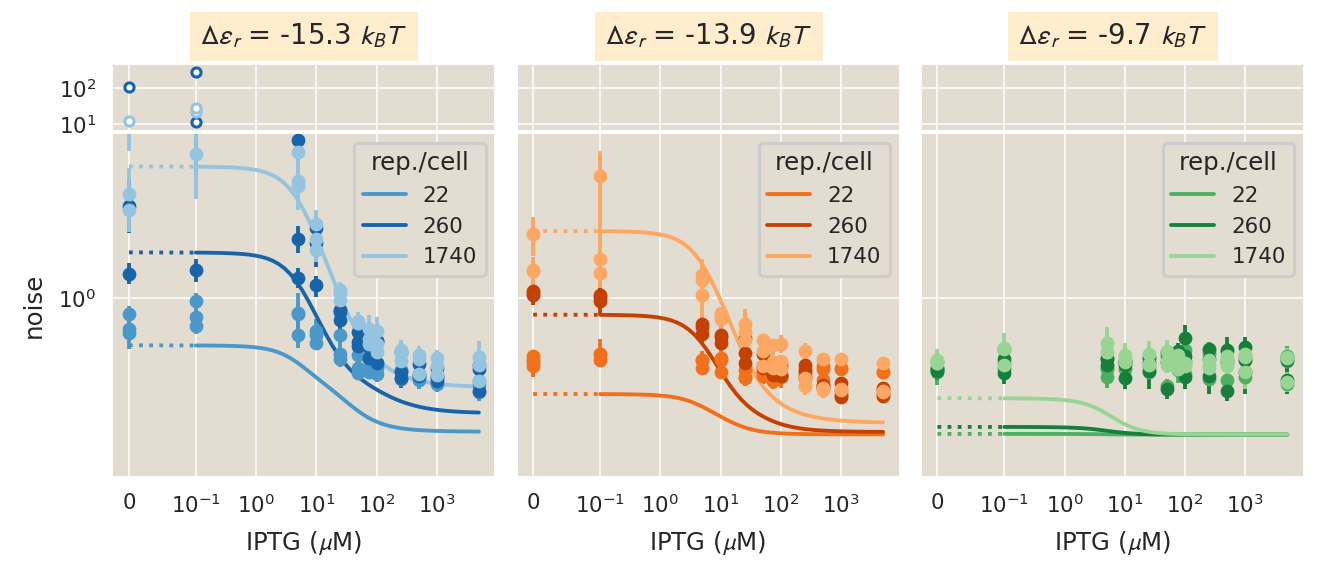

In [81]:
# Initialize figure
fig, ax = plt.subplots(
    2,
    3,
    figsize=(7, 2.5),
    sharex=True,
    sharey="row",
    gridspec_kw={"height_ratios": [1, 5], "wspace": 0.05, "hspace": 0},
)
ax = ax.ravel()
# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]] + 3].plot(
        data[data.inducer_uM >= thresh].inducer_uM,
        data[data.inducer_uM >= thresh].p_noise,
        color=col_dict[group[0]][group[1]],
        label=int(group[1]),
    )
    # Linear scale
    ax[op_idx[group[0]] + 3].plot(
        data[data.inducer_uM <= thresh].inducer_uM,
        data[data.inducer_uM <= thresh].p_noise,
        color=col_dict[group[0]][group[1]],
        label="",
        linestyle=":",
    )

# Set threshold for data
dthresh = 10
# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot data points on lower plot
    ax[op_idx[group[0]] + 3].errorbar(
        x=data.IPTG_uM,
        y=data.noise,
        yerr=[data.noise - data.noise_lower, data.noise_upper - data.noise],
        fmt="o",
        ms=3.5,
        color=col_dict[group[0]][group[1]],
        label="",
    )
    # Plot same data points with different plotting style on the upper row
    ax[op_idx[group[0]]].plot(
        data[data.noise > dthresh].IPTG_uM,
        data[data.noise > dthresh].noise,
        linestyle="--",
        color="w",
        label="",
        lw=0,
        marker="o",
        markersize=3,
        markeredgecolor=col_dict[group[0]][group[1]],
    )

# Set scales of reference plots and the other ones will follow
ax[0].set_xscale("symlog", linthreshx=thresh, linscalex=1)
ax[0].set_yscale("log")
ax[3].set_yscale("log")

# Set limits of reference plots and the rest will folow
ax[3].set_ylim(top=6)
ax[0].set_ylim([6, 5e2])

# Set ticks for the upper plot
ax[0].set_yticks([1e1, 1e2])

# Define location for secondary legend
leg2_loc = ["lower left"] * 2 + ["upper left"]

for i in range(3):
    # Set title
    label = r"$\Delta\epsilon_r$ = {:.1f} $k_BT$".format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor="#ffedce"))
    # Label axis
    ax[i + 3].set_xlabel(r"IPTG ($\mu$M)")
    # Set legend
    leg = ax[i + 3].legend(title="rep./cell", fontsize=7)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=8)
ax[3].set_ylabel(r"noise");

We can see that the model has the right scaling buy systematically fails to pass through the points. Let's take a different look of this. We'll plot the predicted noise vs the measured noise. For this we'll first add an extra column to the experimental data `DataFrame` containing the theoreticla prediction.

In [82]:
# Initialize list to save theoretical noise
# and theoretical mean
thry_noise = list()
thry_mean = list()
# Iterate through rows
for idx, row in df_noise.iterrows():
    # Extract information
    rep = float(row.repressor)
    op = row.operator
    if np.isnan(row.IPTG_uM):
        iptg = 0
    else:
        iptg = row.IPTG_uM
    
    # Extract equivalent theoretical prediction
    thry = df_mom_rep[(df_mom_rep.repressor == rep) &
                       (df_mom_rep.operator == op) &
                       (df_mom_rep.inducer_uM == iptg)].p_noise
    # Append to list
    thry_noise.append(thry.iloc[0])
    # Extract equivalent theoretical prediction
    thry = df_mom_rep[(df_mom_rep.repressor == rep) &
                       (df_mom_rep.operator == op) &
                       (df_mom_rep.inducer_uM == iptg)].m0p1
    # Append to list
    thry_mean.append(thry.iloc[0])
    
    
    
df_noise = df_noise.assign(
    noise_theory=thry_noise,
    mean_theory=thry_mean
)

df_noise.head()

date  IPTG_uM operator  binding_energy  repressor  percentile  \
7   20161203      NaN       O2           -13.9          0        0.95   
16  20161203      0.0       O2           -13.9        260        0.95   
25  20161203      0.1       O2           -13.9        260        0.95   
34  20161203      5.0       O2           -13.9        260        0.95   
43  20161203     10.0       O2           -13.9        260        0.95   

    fold_change  fold_change_lower  fold_change_upper     noise  noise_lower  \
7           NaN                NaN                NaN  0.370025     0.338444   
16     0.011392           0.010277           0.012484  1.051956     0.929280   
25     0.016026           0.014588           0.017549  0.972281     0.836680   
34     0.031860           0.029661           0.034053  0.734542     0.676769   
43     0.068092           0.063424           0.073063  0.673551     0.611979   

    noise_upper  skewness  skewness_lower  skewness_upper  noise_theory  \
7      0.400370  0.825615        0.504992        1.124500      0.229598   
16     1.168843  2.864692        1.929558        3.617530      0.836676   
25     1.127700  3.347587        1.846383        4.527860      0.834999   
34     0.792059  1.958301        1.394289        2.494863      0.610482   
43     0.731952  2.170599        1.773357        2.542889      0.454376   

    mean_theory  
7   9177.732702  
16   115.071071  
25   115.584056  
34   238.750153  
43   523.424313

Let's now plot predicted vs. measured noise. We'll display both a linear and a log-log plot.

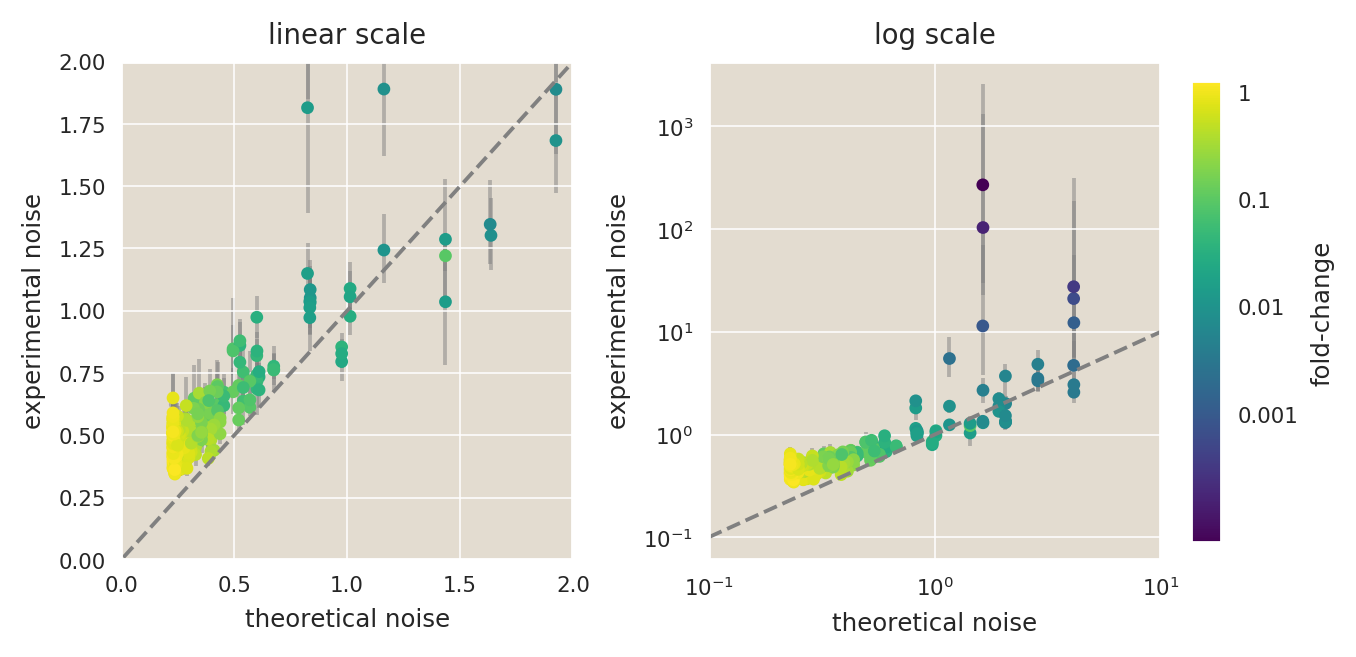

In [83]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Linear scale

# Plot reference line
ax[0].plot([1e-2, 1e2], [1e-2, 1e2], "--", color="gray")

# Plot error bars
ax[0].errorbar(
    x=df_noise.noise_theory,
    y=df_noise.noise,
    yerr=[
        df_noise.noise - df_noise.noise_lower,
        df_noise.noise_upper - df_noise.noise,
    ],
    color="gray",
    alpha=0.5,
    mew=0,
    zorder=0,
    fmt=".",
)

# Plot data with color depending on log fold-change
ax[0].scatter(
    df_noise.noise_theory,
    df_noise.noise,
    c=np.log10(df_noise.fold_change),
    cmap="viridis",
    s=10,
)

ax[0].set_xlabel("theoretical noise")
ax[0].set_ylabel("experimental noise")
ax[0].set_title("linear scale")

# ax[0].set_xticks([0, 1, 2, 3, 4])
# ax[0].set_yticks([0, 1, 2, 3, 4])
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0, 2)

# Log scale

# Plot reference line
line = [1e-1, 1e2]
ax[1].loglog(line, line, "--", color="gray")
# Plot data with color depending on log fold-change

ax[1].errorbar(
    x=df_noise.noise_theory,
    y=df_noise.noise,
    yerr=[
        df_noise.noise - df_noise.noise_lower,
        df_noise.noise_upper - df_noise.noise,
    ],
    color="gray",
    alpha=0.5,
    mew=0,
    zorder=0,
    fmt=".",
)

plot = ax[1].scatter(
    df_noise.noise_theory,
    df_noise.noise,
    c=np.log10(df_noise.fold_change),
    cmap="viridis",
    s=10,
)

ax[1].set_xlabel("theoretical noise")
ax[1].set_ylabel("experimental noise")
ax[1].set_title("log scale")
ax[1].set_xlim([0.1, 10])

# show color scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(plot, cax=cbar_ax, ticks=[0, -1, -2, -3])

cbar.ax.set_ylabel("fold-change")
cbar.ax.set_yticklabels(["1", "0.1", "0.01", "0.001"])
cbar.ax.tick_params(width=0)

plt.subplots_adjust(wspace=0.3)

Again, the scaling of the predictions is in agreement with the data, but the bulk of the measurements, i.e. the noise measurements between 0 and 1, are all systematically above the curve. We'll now try some empirical adjustments to guide our intuition of the origin of these deviations.

### Empirical multiplicative constant

The first thing that we will attempt to fix this data is a simple empirical constant. What this means is that the experimental noise and the theoretical noise are related as
$$
\text{noise}_{\exp} = \alpha \cdot \text{noise}_{\text{theory}},
\tag{2}
$$
where $\alpha$ is a multiplicative constant that accounts for the systematic deviation between our predictions and the data. Since our predictions fall below the measured noise we expect $\alpha > 1$. To find this value we will perform a linear regression with a **fixed intercept at zero**. To give less weight to the measurements with extremely large noise values (associated with measurement errors since the expression of these highly repressed cells is very close to the autofluorescence background) we will perform the regression in log scale. We'll also weigh each of the datum by the width of the bootstrap confidence interval on the noise measurement. In this way we force points with high noise and and high confidence interval to influence less in the regression.

Notice that fitting the slope in linear scale is equivalent to finding an intercept for a fix slope in log scale. Let's go ahead and perform this regression. We will weight each of the datum by the width of their confidence interval and their fold-change value.

In [84]:
# Select data with experimetal noise < 10
data = df_noise[df_noise.noise < 10]
# Define the weights for each of the datum to be the width
# of their bootstrap confidence interval.
noise_range = (data.noise_upper.values - data.noise_lower.values)

weights = noise_range
# Assign the non-zero minimum value to all zero weights
weights[weights == 0] = min(weights[weights > 0])

# Normalize weights
weights = weights / weights.sum()

def mult_factor(x, a):
    '''
    Function to find additive constant used with scipy curve_fit
    '''
    return a * x

popt, pcov = sp.optimize.curve_fit(
    mult_factor,
    data.noise_theory.values,
    data.noise.values,
    sigma=weights,
)

multiplicative = popt[0]
# Print result
print(
    f"Multiplicative factor: {multiplicative}"
)

Multiplicative factor: 1.5243963036013917


So the multiplicative factor is ≈ 1.5. Let's plot the predictions multiplied by this factor vs the data to see if there is an improvement.

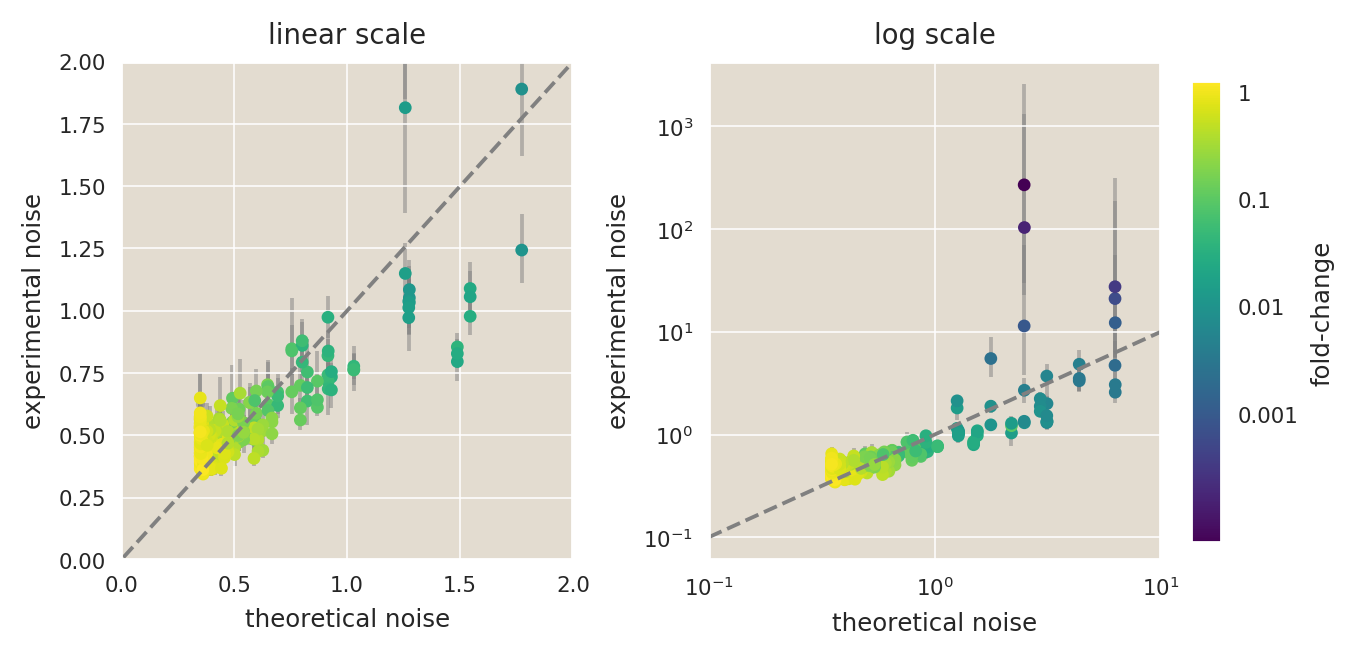

In [85]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Linear scale

# Plot reference line
ax[0].plot([1E-2, 1E2], [1E-2, 1E2], '--', color='gray')

# Plot error bars
ax[0].errorbar(x=df_noise.noise_theory * multiplicative,
               y=df_noise.noise,
               yerr=[df_noise.noise - df_noise.noise_lower,
                     df_noise.noise_upper - df_noise.noise],
               color='gray',
               alpha=0.5,
               mew=0,
               zorder=0,
               fmt='.')

# Plot data with color depending on log fold-change
ax[0].scatter(df_noise.noise_theory * multiplicative, df_noise.noise, 
              c=np.log10(df_noise.fold_change), cmap='viridis',
              s=10)

ax[0].set_xlabel('theoretical noise')
ax[0].set_ylabel('experimental noise')
ax[0].set_title('linear scale')

ax[0].set_xlim(0, 2)
ax[0].set_ylim(0, 2);
# ax[0].set_xticks([0, 1, 2, 3, 4, 6])
# ax[0].set_yticks([0, 1, 2, 3, 4, 6])

# Log scale

# Plot reference line
line = [1E-1, 1E2]
ax[1].loglog(line, line, '--', color='gray')
# Plot data with color depending on log fold-change

ax[1].errorbar(x=df_noise.noise_theory * multiplicative,
               y=df_noise.noise,
               yerr=[df_noise.noise - df_noise.noise_lower,
                     df_noise.noise_upper - df_noise.noise],
               color='gray',
               alpha=0.5,
               mew=0,
               zorder=0,
               fmt='.')

plot = ax[1].scatter(df_noise.noise_theory * multiplicative,
                     df_noise.noise, 
                     c=np.log10(df_noise.fold_change), cmap='viridis',
                     s=10)

ax[1].set_xlabel('theoretical noise')
ax[1].set_ylabel('experimental noise')
ax[1].set_title('log scale')
ax[1].set_xlim([0.1, 10])

# show color scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(plot, cax=cbar_ax, ticks=[0, -1, -2, -3])

cbar.ax.set_ylabel('fold-change')
cbar.ax.set_yticklabels(['1', '0.1', '0.01', '0.001'])
cbar.ax.tick_params(width=0) 

plt.subplots_adjust(wspace=0.3)

there is definitely an improvement. Let's take a different look. We'll plot again noise as a function of inducer concentration.

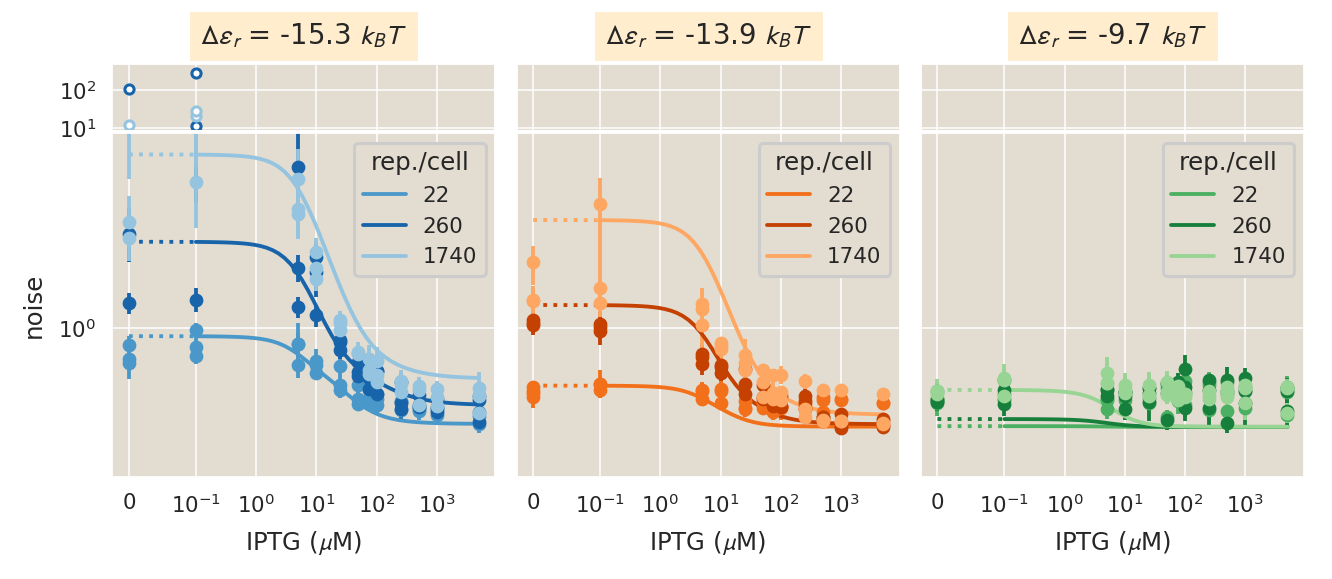

In [86]:
# Initialize figure
fig, ax = plt.subplots(
    2,
    3,
    figsize=(7, 2.5),
    sharex=True,
    sharey="row",
    gridspec_kw={"height_ratios": [1, 5], "wspace": 0.05, "hspace": 0},
)
ax = ax.ravel()
# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]] + 3].plot(
        data[data.inducer_uM >= thresh].inducer_uM,
        data[data.inducer_uM >= thresh].p_noise * multiplicative,
        color=col_dict[group[0]][group[1]],
        label=int(group[1]),
    )
    # Linear scale
    ax[op_idx[group[0]] + 3].plot(
        data[data.inducer_uM <= thresh].inducer_uM,
        data[data.inducer_uM <= thresh].p_noise * multiplicative,
        color=col_dict[group[0]][group[1]],
        label="",
        linestyle=":",
    )

# Set threshold for data
dthresh = 10
# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot data points on lower plot
    ax[op_idx[group[0]] + 3].errorbar(
        x=data.IPTG_uM,
        y=data.noise,
        yerr=[data.noise - data.noise_lower, data.noise_upper - data.noise],
        fmt="o",
        ms=3.5,
        color=col_dict[group[0]][group[1]],
        label="",
    )
    # Plot same data points with different plotting style on the upper row
    ax[op_idx[group[0]]].plot(
        data[data.noise > dthresh].IPTG_uM,
        data[data.noise > dthresh].noise,
        linestyle="--",
        color="w",
        label="",
        lw=0,
        marker="o",
        markersize=3,
        markeredgecolor=col_dict[group[0]][group[1]],
    )

# Set scales of reference plots and the other ones will follow
ax[0].set_xscale("symlog", linthreshx=thresh, linscalex=1)
ax[0].set_yscale("log")
ax[3].set_yscale("log")

# Set limits of reference plots and the rest will folow
ax[3].set_ylim(top=8)
ax[0].set_ylim([8, 5e2])

# Set ticks for the upper plot
ax[0].set_yticks([1e1, 1e2])

# Define location for secondary legend
leg2_loc = ["lower left"] * 2 + ["upper left"]

for i in range(3):
    # Set title
    label = r"$\Delta\epsilon_r$ = {:.1f} $k_BT$".format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor="#ffedce"))
    # Label axis
    ax[i + 3].set_xlabel(r"IPTG ($\mu$M)")
    # Set legend
    leg = ax[i + 3].legend(title="rep./cell", fontsize=7)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=8)
ax[3].set_ylabel(r"noise");

There is a notorious improvement for our noise predictions. For completeness let's test another potential empirical fix.

### Empirical additive constant

Another possible empirical improvement from our predictions would come from an additive constant. What this means is that the experimental and theoretical noise are related as
$$
\text{noise}_{\exp} = \beta + \text{noise}_{\text{theory}},
\tag{3}
$$
where $\beta$ is our empirical additive constant. Since there is no easy way to do this in log scale, let's try it in linear scale. Again we will weight each of the datum by their error and their fold-change values.

In [87]:
# Select data with experimetal noise < 10
data = df_noise[df_noise.noise < 10]
# Define the weights for each of the datum to be the width
# of their bootstrap confidence interval.
noise_range = (data.noise_upper.values - data.noise_lower.values)

weights = noise_range
# Assign the non-zero minimum value to all zero weights
weights[weights == 0] = min(weights[weights > 0])

# Normalize weights
weights = weights / weights.sum()

def add_factor(x, a):
    '''
    Function to find additive constant used with scipy curve_fit
    '''
    return a + x

popt, pcov = sp.optimize.curve_fit(
    add_factor,
    data.noise_theory.values,
    data.noise.values,
    sigma=weights,
)

additive = popt[0]
# Print result
print(
    f"Additive factor: {additive}"
)

Additive factor: 0.1947245359371309


Just as before, let's take a look a what the additive constant does to the data.

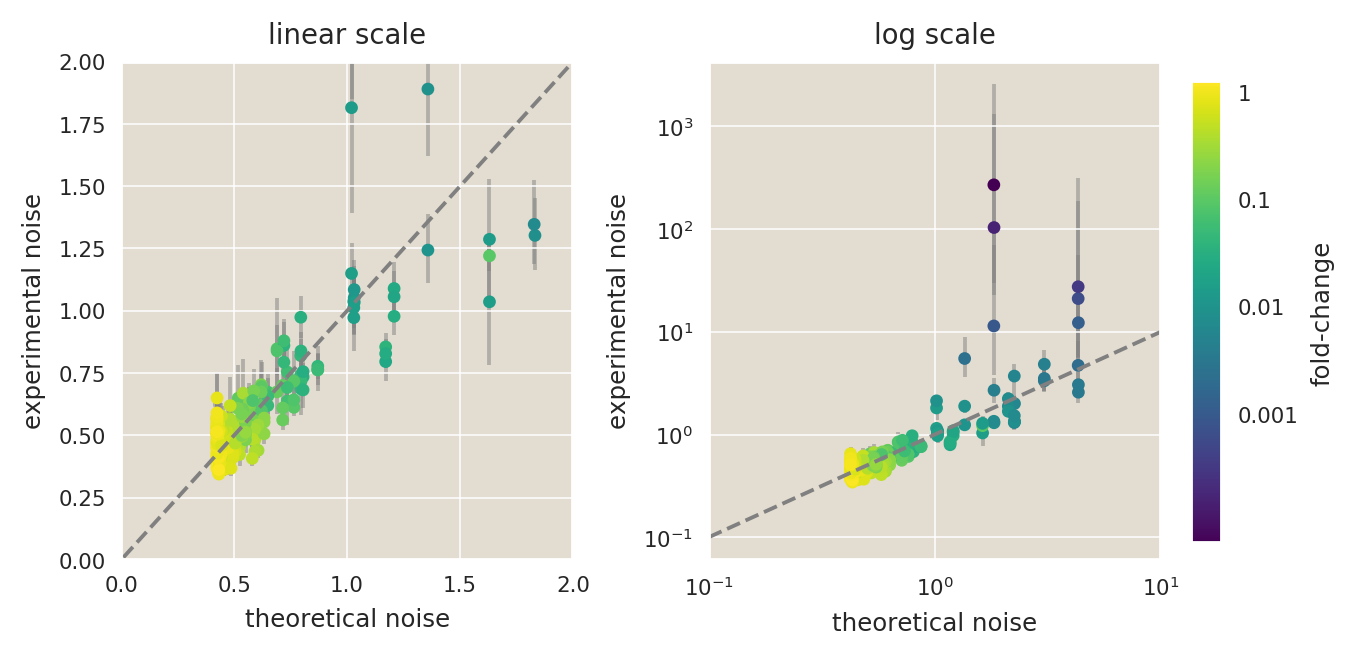

In [88]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

# Linear scale

# Plot reference line
ax[0].plot([1E-2, 1E2], [1E-2, 1E2], '--', color='gray')

# Plot error bars
ax[0].errorbar(x=df_noise.noise_theory + additive,
               y=df_noise.noise,
               yerr=[df_noise.noise - df_noise.noise_lower,
                     df_noise.noise_upper - df_noise.noise],
               color='gray',
               alpha=0.5,
               mew=0,
               zorder=0,
               fmt='.')

# Plot data with color depending on log fold-change
ax[0].scatter(df_noise.noise_theory + additive, df_noise.noise, 
              c=np.log10(df_noise.fold_change), cmap='viridis',
              s=10)

ax[0].set_xlabel('theoretical noise')
ax[0].set_ylabel('experimental noise')
ax[0].set_title('linear scale')

ax[0].set_xlim(0, 2)
ax[0].set_ylim(0, 2);
# ax[0].set_xticks([0, 1, 2, 3, 4, 6])
# ax[0].set_yticks([0, 1, 2, 3, 4, 6])

# Log scale

# Plot reference line
line = [1E-1, 1E2]
ax[1].loglog(line, line, '--', color='gray')
# Plot data with color depending on log fold-change

ax[1].errorbar(x=df_noise.noise_theory + additive,
               y=df_noise.noise,
               yerr=[df_noise.noise - df_noise.noise_lower,
                     df_noise.noise_upper - df_noise.noise],
               color='gray',
               alpha=0.5,
               mew=0,
               zorder=0,
               fmt='.')

plot = ax[1].scatter(df_noise.noise_theory + additive,
                     df_noise.noise, 
                     c=np.log10(df_noise.fold_change), cmap='viridis',
                     s=10)

ax[1].set_xlabel('theoretical noise')
ax[1].set_ylabel('experimental noise')
ax[1].set_title('log scale')
ax[1].set_xlim([0.1, 10])

# show color scale
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar = fig.colorbar(plot, cax=cbar_ax, ticks=[0, -1, -2, -3])

cbar.ax.set_ylabel('fold-change')
cbar.ax.set_yticklabels(['1', '0.1', '0.01', '0.001'])
cbar.ax.tick_params(width=0) 

plt.subplots_adjust(wspace=0.3)

For completeness, let's look at the noise as a function of inducer concentration.

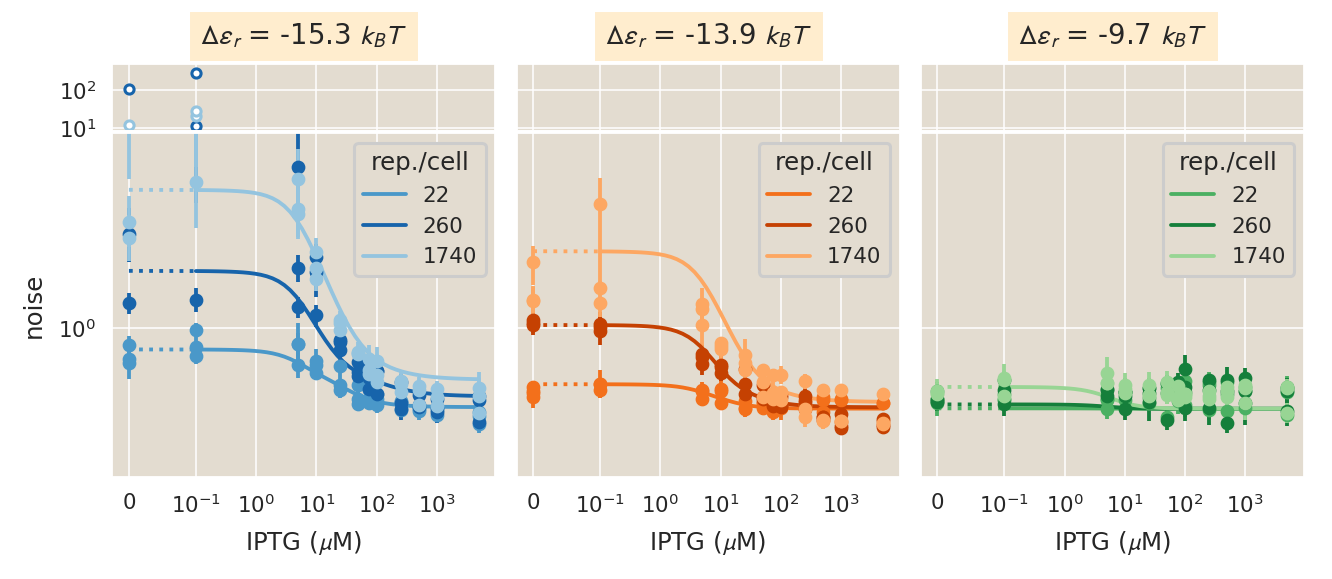

In [89]:
# Initialize figure
fig, ax = plt.subplots(
    2,
    3,
    figsize=(7, 2.5),
    sharex=True,
    sharey="row",
    gridspec_kw={"height_ratios": [1, 5], "wspace": 0.05, "hspace": 0},
)
ax = ax.ravel()
# Loop through groups on multi-promoter
for i, (group, data) in enumerate(df_group):
    # Log scale
    ax[op_idx[group[0]] + 3].plot(
        data[data.inducer_uM >= thresh].inducer_uM,
        data[data.inducer_uM >= thresh].p_noise + additive,
        color=col_dict[group[0]][group[1]],
        label=int(group[1]),
    )
    # Linear scale
    ax[op_idx[group[0]] + 3].plot(
        data[data.inducer_uM <= thresh].inducer_uM,
        data[data.inducer_uM <= thresh].p_noise + additive,
        color=col_dict[group[0]][group[1]],
        label="",
        linestyle=":",
    )

# Set threshold for data
dthresh = 10
# Loop through groups on experimental data
for i, (group, data) in enumerate(df_group_exp):
    # Plot data points on lower plot
    ax[op_idx[group[0]] + 3].errorbar(
        x=data.IPTG_uM,
        y=data.noise,
        yerr=[data.noise - data.noise_lower, data.noise_upper - data.noise],
        fmt="o",
        ms=3.5,
        color=col_dict[group[0]][group[1]],
        label="",
    )
    # Plot same data points with different plotting style on the upper row
    ax[op_idx[group[0]]].plot(
        data[data.noise > dthresh].IPTG_uM,
        data[data.noise > dthresh].noise,
        linestyle="--",
        color="w",
        label="",
        lw=0,
        marker="o",
        markersize=3,
        markeredgecolor=col_dict[group[0]][group[1]],
    )

# Set scales of reference plots and the other ones will follow
ax[0].set_xscale("symlog", linthreshx=thresh, linscalex=1)
ax[0].set_yscale("log")
ax[3].set_yscale("log")

# Set limits of reference plots and the rest will folow
ax[3].set_ylim(top=8)
ax[0].set_ylim([8, 5e2])

# Set ticks for the upper plot
ax[0].set_yticks([1e1, 1e2])

# Define location for secondary legend
leg2_loc = ["lower left"] * 2 + ["upper left"]

for i in range(3):
    # Set title
    label = r"$\Delta\epsilon_r$ = {:.1f} $k_BT$".format(energies[i])
    ax[i].set_title(label, bbox=dict(facecolor="#ffedce"))
    # Label axis
    ax[i + 3].set_xlabel(r"IPTG ($\mu$M)")
    # Set legend
    leg = ax[i + 3].legend(title="rep./cell", fontsize=7)
    # Set legend font size
    plt.setp(leg.get_title(), fontsize=8)
ax[3].set_ylabel(r"noise");

One could argue that this looks even better than the multiplicative constant. As a way of comparison we will compute an $R^2$ for each of the cases. Notices that although the noise as a function of inducer concentration is a non-linear fit for which we couldn't compute an $R^2$, both the multiplicative and the additive constant as we inferred them are simple linear linear regressions for which we can compute such numbers. Only large differences in these numbers will be revealing.

In [112]:
data = df_noise[df_noise.noise < 10]
# Original regression
r_sqr_original = np.corrcoef(
    data.noise_theory.values,
    data.noise.values,
)[0, 1]**2
# Multiplicative constant
r_sqr_mult = np.corrcoef(
    data.noise_theory.values * multiplicative,
    data.noise.values,
)[0, 1]**2
# Additive constant
r_sqr_add = np.corrcoef(
    data.noise_theory.values + additive,
    data.noise.values,
)[0, 1]**2

print(
f'''
Original R**2 = {r_sqr_original}
Multiplicative factor R**2 = {r_sqr_mult}
Additive factor R**2 = {r_sqr_add}
'''
)


Original R**2 = 0.7045558802761537
Multiplicative factor R**2 = 0.7045558802761533
Additive factor R**2 = 0.7045558802761537



Completely indistinguishable as far as this metric is concerned.